In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
import matplotlib.pyplot as plt
sys.path.append('../..')
from sklearn.tree import DecisionTreeRegressor
import imodels
from viz import *
import copy
import json


mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [2]:
def plot_sim(n=50, std=1, reg_param=0, show=True, linear_data=False, return_curves=False, shrinkage_scheme='tv', ax=None):
    np.random.seed(13)

    if linear_data:
        def gt_func(X):
            return X
    else:
        def gt_func(X):
            return +1 * (X < 2) * (X < 1) + \
                   -0 * (X < 2) * (X > 1) + \
                   +1 * (X >= 2) * (X < 3) + \
                   +0 * (X >= 2) * (X > 3)

    # data to fit
    X = np.random.uniform(0, 4, n)
    X = np.sort(X)
    y = gt_func(X) + np.random.normal(0, 1, n) * std


    # data to plot
    X_tile = np.linspace(0, 4, 400)
    y_tile = gt_func(X_tile)

    m1 = DecisionTreeRegressor(random_state=1)  #, max_leaf_nodes=15)
    m1.fit(X.reshape(-1, 1), y)
    y_pred_dt = m1.predict(X_tile.reshape(-1, 1))

    mshrunk = imodels.HSTreeRegressor(deepcopy(m1), reg_param=reg_param, shrinkage_scheme_=shrinkage_scheme)
    y_pred_shrunk = mshrunk.predict(X_tile.reshape(-1, 1))
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4))

    ax.plot(X, y, 'o', color='black', ms=4, alpha=0.5, markeredgewidth=0)
    ax.plot(X_tile, y_tile, label='Groundtruth', color='black', lw=3)
    ax.plot(X_tile, y_pred_dt, '-', label='CART', color=cb, alpha=0.5, lw=4)
    ax.plot(X_tile, y_pred_shrunk, label='hsCART', color='#ff4b33', alpha=0.5, lw=4)
    ax.set_xlabel('X')
    ax.set_xlabel('Y')
    ax.set_title(f"reg scheme: {shrinkage_scheme}")
    dvu.line_legend(adjust_text_labels=False)
    if show == 'save':
        plt.savefig(f'gif/{reg_param}.svg')
    elif show == 'pass':
        pass
    elif show:
        plt.show()
    else:
        plt.close()

    if return_curves:
        return X, y, X_tile, y_tile, y_pred_dt, y_pred_shrunk


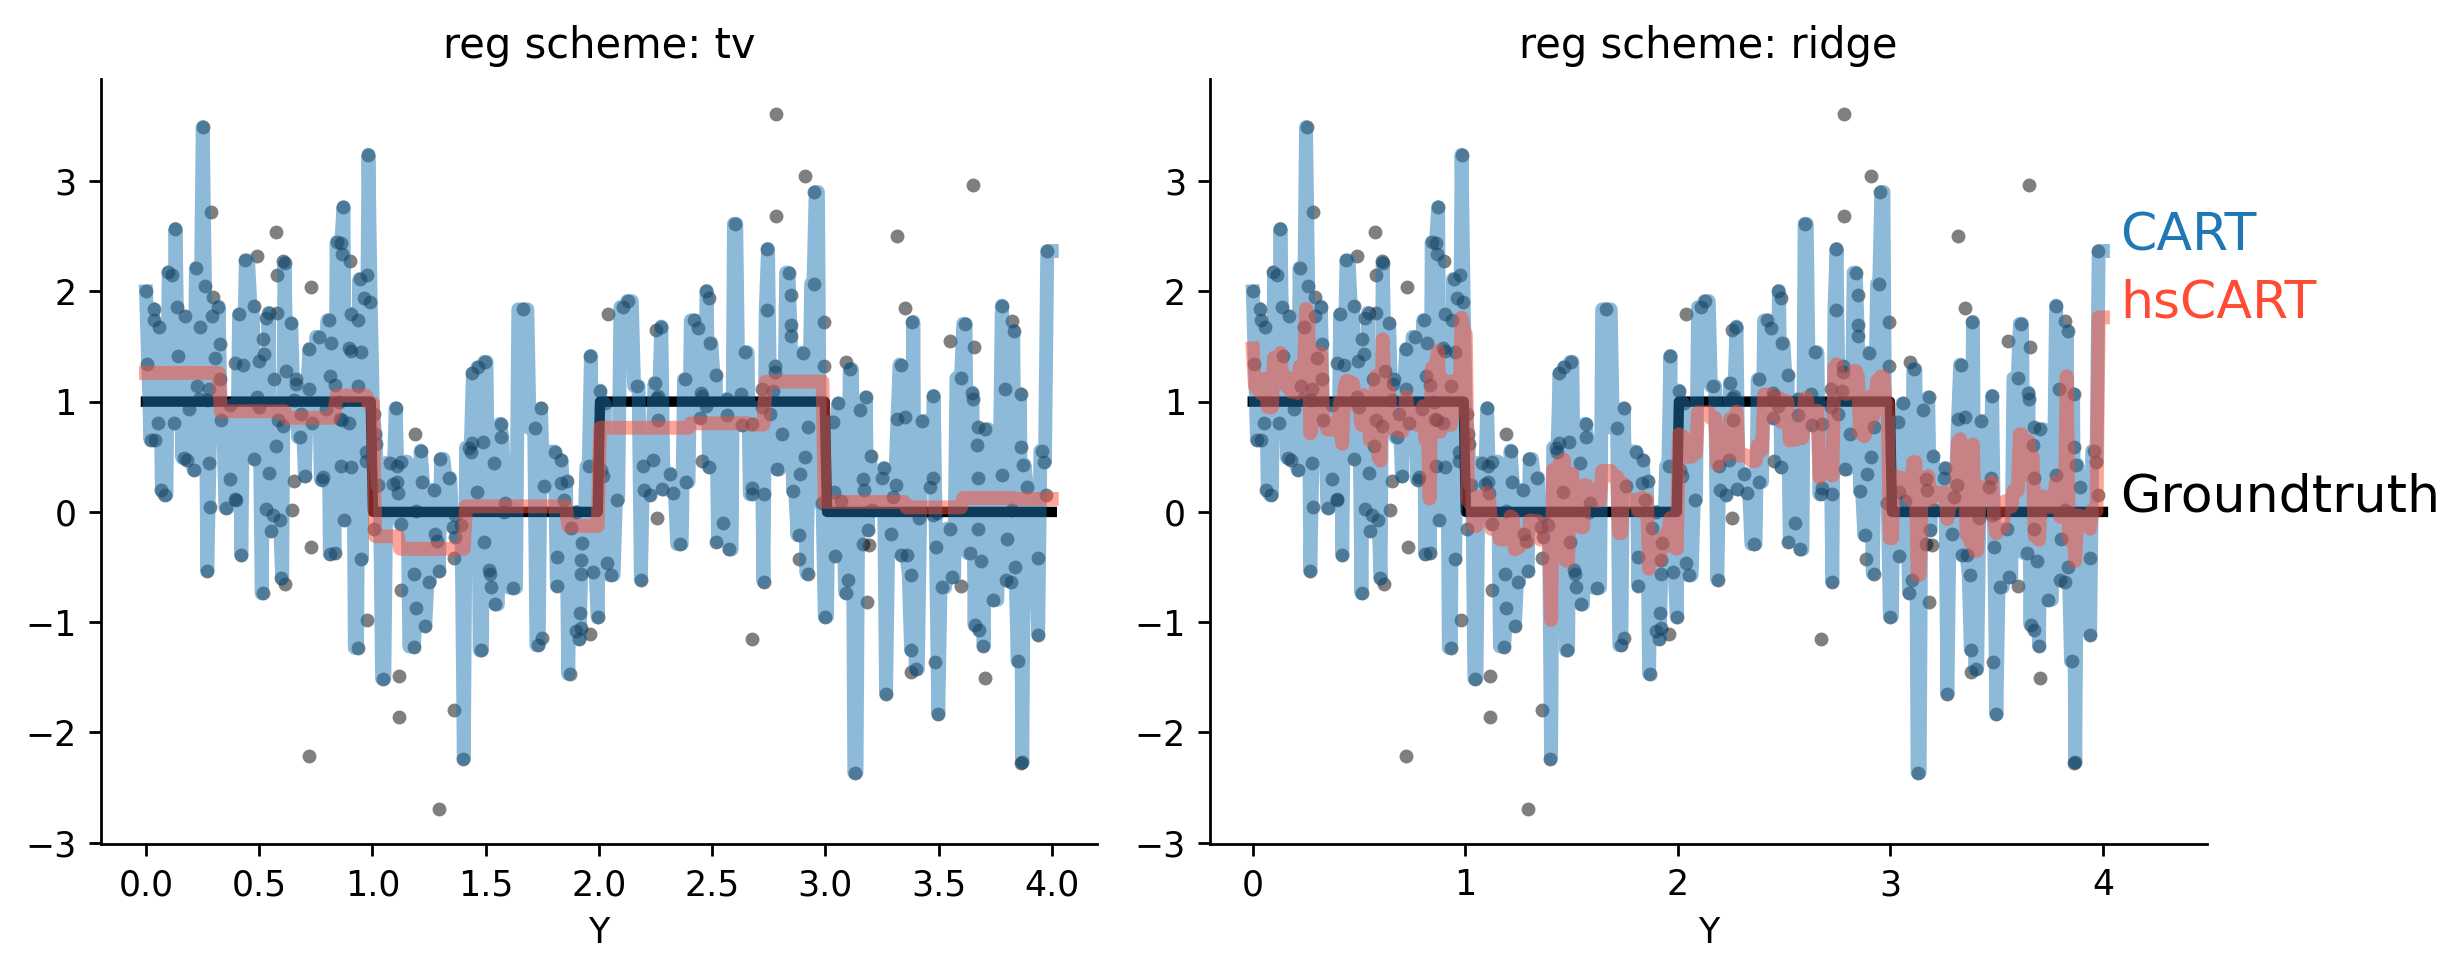

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_sim(n=400, std=1, reg_param=1, show='pass', shrinkage_scheme="tv", ax=axs[0])
plot_sim(n=400, std=1, reg_param=40, show='pass', shrinkage_scheme="ridge", ax=axs[1])


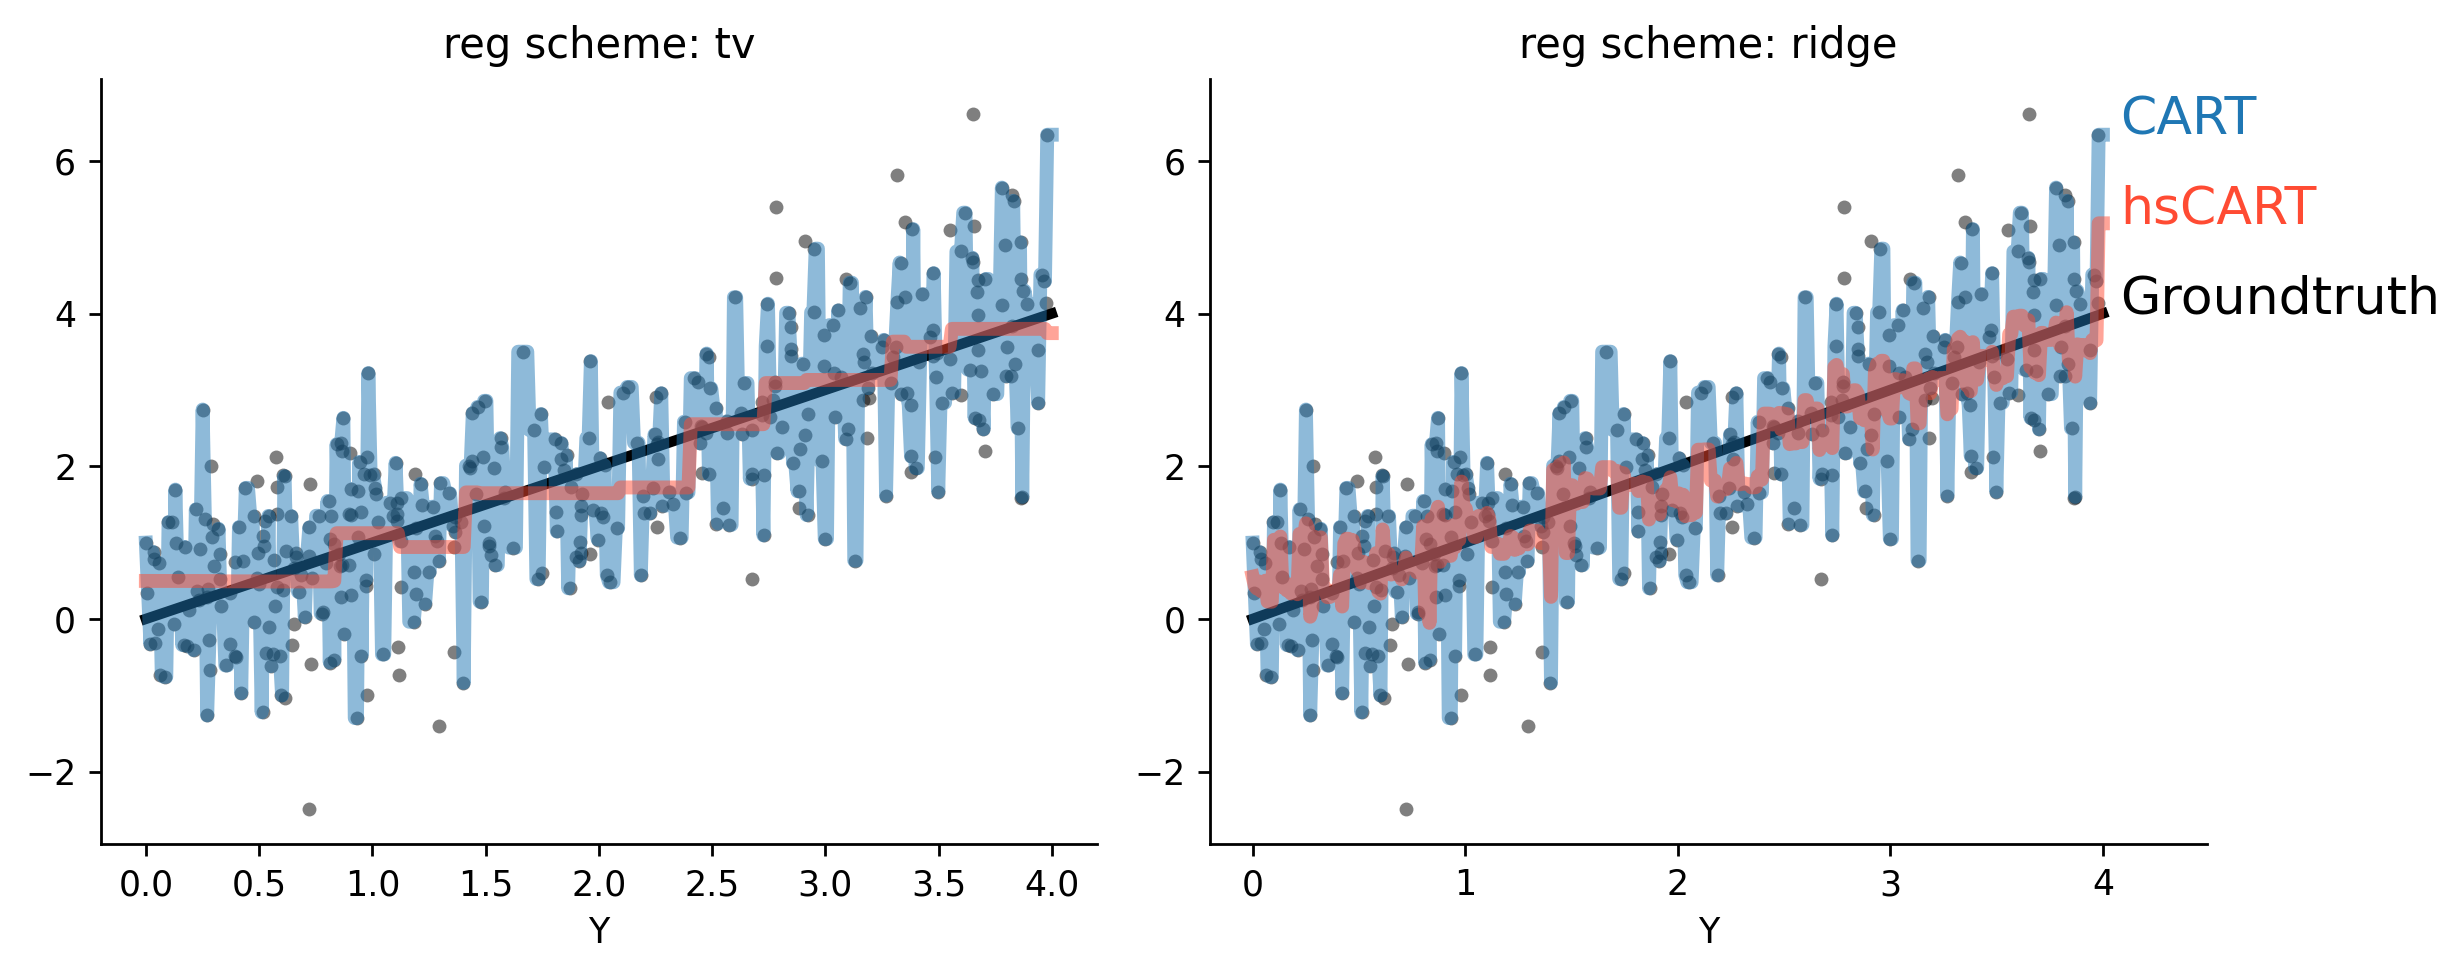

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plot_sim(n=400, std=1, reg_param=1, show='pass', shrinkage_scheme="tv", ax=axs[0], linear_data = True)
plot_sim(n=400, std=1, reg_param=40, show='pass', shrinkage_scheme="ridge", ax=axs[1], linear_data = True)


# compare running time with ccp pruning


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['friedman1', 'friedman3', 'diabetes-regr', 'geographical-music', 'red-wine', 'abalone', 'satellite-image', 'california-housing', 'heart', 'breast-cancer', 'haberman', 'ionosphere', 'diabetes', 'german-credit', 'juvenile', 'recidivism']

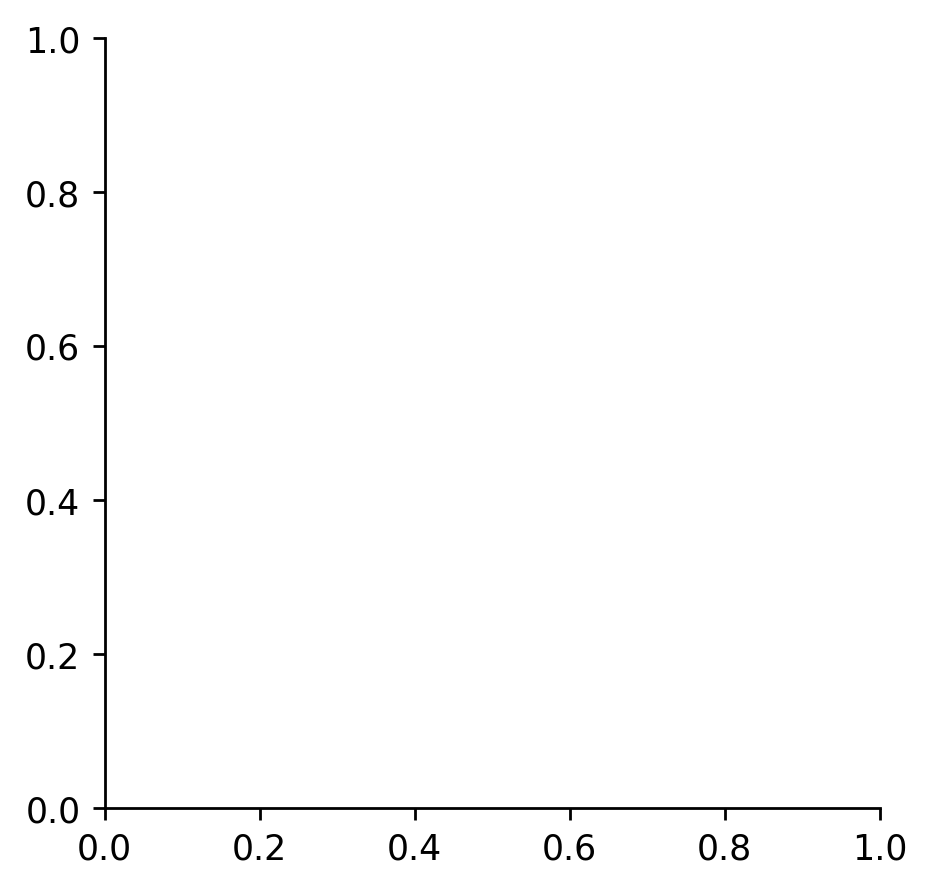

In [4]:
# load running_time, performance and data_sizes from config/shrinkage/ccp_expr.json file
with open('/accounts/campus/omer_ronen/projects/imodels-experiments/ccp_expr.json', 'r') as f:
    data = json.load(f)
running_time = data['running_time']
performance = data['performance']
data_sizes = data['data_sizes']
data_sizes = 4* (np.array(data_sizes) / np.max(data_sizes))
dataset_name = data['dataset']

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# plot running time vs performance, color accodring the different datasets and shape according to the method, size according to the data size

ax.scatter(running_time['ccp'], performance['ccp'], s=data_sizes, label='ccp', c=dataset_name)
ax.scatter(running_time['tv'], performance['tv'], s=data_sizes, label='tv', c=dataset_name)
ax.set_xlabel('running time (seconds)')
ax.set_ylabel('test mse')
ax.legend()
plt.show()



In [10]:
from sklearn.datasets import make_friedman1

X, y = make_friedman1(n_samples=1000, n_features=10, random_state=0)

cart = DecisionTreeRegressor(max_depth=2)
cart =  cart.fit(X, y)

In [33]:
from imodels import HSTreeRegressor

hs_tv = HSTreeRegressor(copy.deepcopy(cart), shrinkage_scheme_="tv", reg_param=2)
hs_tv._shrink()

hs_ridge = HSTreeRegressor(copy.deepcopy(cart), shrinkage_scheme_="ridge", reg_param=10)
hs_ridge._shrink()

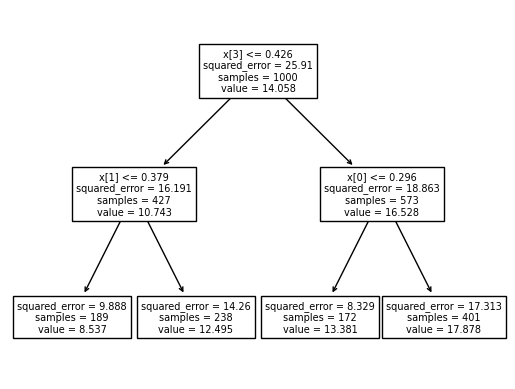

In [34]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(1)
plot_tree(cart, ax=ax)
plt.show()

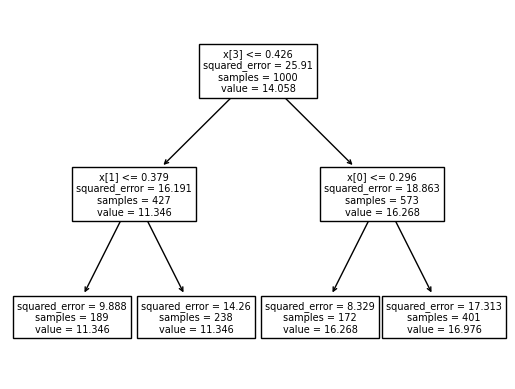

In [35]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(1)
plot_tree(hs_tv.estimator_, ax=ax)
plt.show()

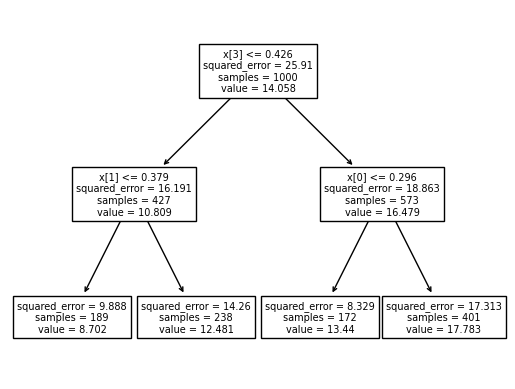

In [26]:
fig, ax = plt.subplots(1)
plot_tree(hs_ridge.estimator_, ax=ax)
plt.show()